In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
last = session.query(Measurement).first()
print(last.__dict__)
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lastdate.date)
#dt.datetime(result[0][0])
#lastdate[0]
one_year = dt.datetime(*[int(r) for r in lastdate.date.split('-')]) - dt.timedelta(days=365)
one_year = one_year.strftime("%Y-%m-%d")
print(one_year)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000028DD149C7F0>, 'prcp': 0.08, 'date': '2010-01-01', 'id': 1, 'tobs': 65.0, 'station': 'USC00519397'}
2017-08-23
2016-08-23


In [12]:
data = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>one_year).order_by(Measurement.date))
#data = data.dropna(subset=['prcp'])
data = data.rename(columns={'prcp':'precipitation'})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028DD149C860>],
      dtype=object)

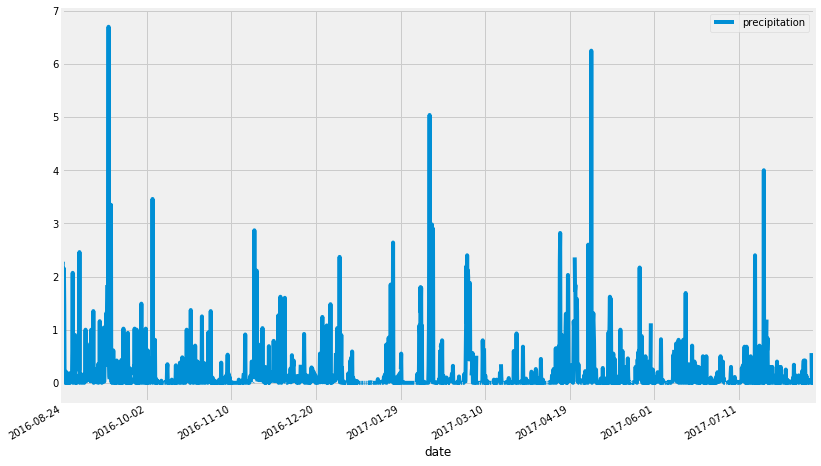

In [13]:
data.set_index('date',inplace=True)
data.plot(subplots=True,figsize=(12, 8))

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
print(f"Number of stations are {session.query(Measurement.station).group_by(Measurement.station).count()}.")

Number of stations are 9.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stations[0][0]
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station==stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationlstdt = session.query(Measurement.date).filter(Measurement.station==stations[0][0]).order_by(Measurement.date.desc()).first()
s = str(stationlstdt[0])
print(s)
s = dt.datetime(*[int(x) for x in s.split("-")]) - dt.timedelta(days=365)
print(s)

2017-08-18
2016-08-18 00:00:00


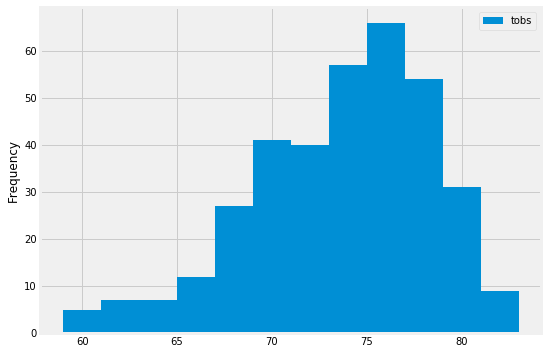

In [19]:
data2 = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                     filter(Measurement.date>s).filter(Measurement.station==stations[0][0]))
data2.plot(kind='hist',figsize=(8, 6),bins=12)

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date > start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(lastdate[0])
print(one_year)
print(calc_temps(one_year, lastdate[0]))

2017-08-23
2016-08-23
[(58.0, 74.57894736842105, 87.0)]


74.57894736842105
0    29.0
dtype: float64


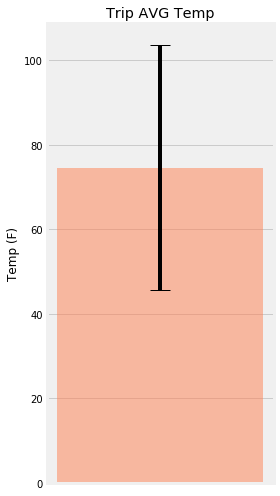

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

data = pd.DataFrame(calc_temps(one_year, lastdate[0]),columns=['TMIN','TAVG','TMAX'])
error = data['TMAX'] - data['TMIN']
print(data['TAVG'][0])
print(error)
xpos = np.arange(len(chart3))

fig = plt.figure(figsize=(4, 7))
plt.bar(xpos,data['TAVG'][0],yerr=error[0:1], align='center', alpha=0.5, ecolor='black', capsize=10, color='coral')
plt.title("Trip AVG Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.tight_layout()
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
